In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import sys
import os
import math
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.join('..', 'lib')))

from dot_product import ScaleDatabase

c:\Users\21361535\AppData\Local\anaconda3\envs\lava3\lib\site-packages\lava\utils\profiler.py:16: UserWarning: Loihi2HWProfiler could not be imported. Currently no profiler is available.
  warnings.warn("Loihi2HWProfiler could not be imported. "


## Download Datasets

In [2]:
D1    = loadmat("../datasets/descriptors/GardensPointWalking/day_left/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']
D2    = loadmat("../datasets/descriptors/GardensPointWalking/day_right/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']
g_truth = loadmat("../datasets/ground_truth/GardensPointWalking/day_right--day_left/gt.mat")

In [3]:
datasets = {}
# Step 1: Load the MNIST dataset (first 1000 samples for speed)
dataset = fetch_openml('mnist_784', version=1)
X = dataset.data.astype(np.float32)[:500]
mu = np.mean(X,axis=0)
dataset_centered = np.subtract(X,mu)
datasets['mnist'] =  normalize(dataset_centered, norm='l2')


c:\Users\21361535\AppData\Local\anaconda3\envs\lava3\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
numeric_datasets = [
    'iris',
    'wine',
    'spambase',
    'concrete-compressive-strength',
    'energy-efficiency',
    'airfoil-self-noise'
]

In [9]:
# Store results
results = {}

# Loop through datasets, load, normalize, and run knn_snn
for name in numeric_datasets:
    try:
        dataset = fetch_openml(name=name, version=1, as_frame=False)
        X = dataset.data.astype(np.float32)
        # V = normalize(X, norm='l2')
        datasets[name] = X
    except Exception as e:
        results[name] = {'error': str(e)}


c:\Users\21361535\AppData\Local\anaconda3\envs\lava3\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [10]:
# add a random dataset
datasets['random'] = np.random.randn(500, 20)



## Mean Center and Normalize

In [7]:
## Mean Center each feature in each dataset
for name, dataset in datasets.items():
    mu = np.mean(dataset,axis=0)
    dataset_centered = np.subtract(dataset,mu)
    datasets[name] =  normalize(dataset_centered, norm='l2')


In [8]:
constant = 1 / math.sqrt(2)

In [64]:
D1_mean_center_norm = ScaleDatabase().mean_center_normalize(D1)
D2_mean_center_norm = ScaleDatabase().mean_center_normalize(D2)

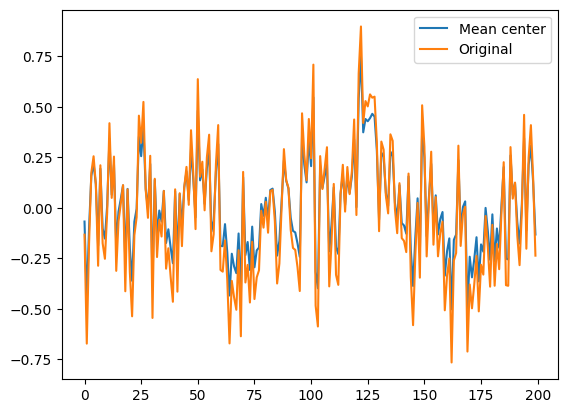

In [65]:
# plt.plot(D1_mean_center_norm[0])
plt.plot(np.mean(D1_mean_center_norm*950, axis=1), label="Mean center")
plt.plot(np.mean(D1, axis=1), label="Original")
plt.legend()
plt.show()


In [66]:
from scipy.spatial.distance import cosine
from sklearn.preprocessing import Normalizer

# mu1 = np.mean(D1_mean_center_norm,axis=0)
# D1_mean_center_norm = np.subtract(D1_mean_center_norm,mu1)

q_id = 100
# Calculate cosine distance between all vectors in D1_mean_center_norm and the query vector
query = D1_mean_center_norm[q_id] / np.linalg.norm(D1_mean_center_norm[q_id])
distances = [cosine(query, vec) for vec in D1_mean_center_norm]

# Sort the vectors based on the cosine distance with the query vector
sorted_vectors = [vec for _, vec in sorted(zip(distances, D1_mean_center_norm))]


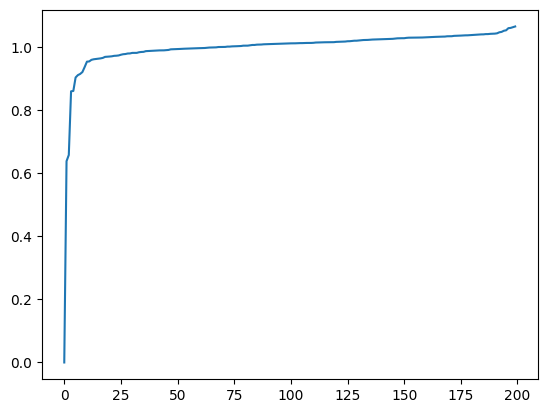

In [67]:
plt.plot([cosine(query, vec) for vec in sorted_vectors])

In [68]:

const_vec = np.ones_like(query).reshape(1, -1)
const_vec = Normalizer().fit_transform(const_vec)[0]


In [69]:
const_vec.shape


(4096,)

In [70]:
def E(u, v, c):
    u_c = u + c
    v_c = v + c
    return np.linalg.norm(u_c) / np.linalg.norm(v_c)


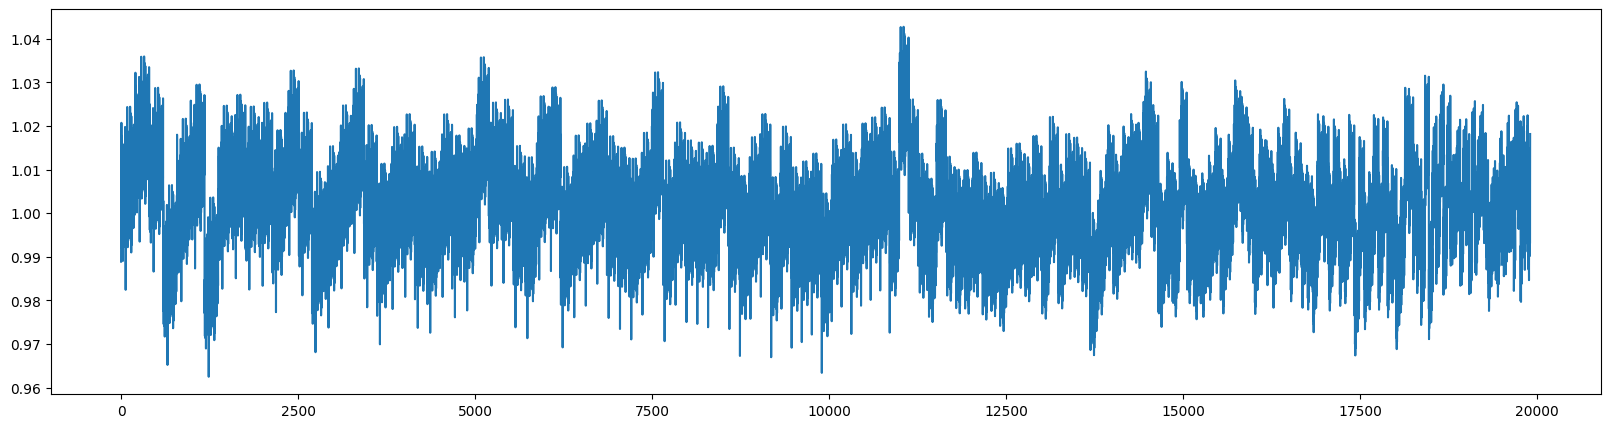

In [71]:
E_list = []
for i in range(len(sorted_vectors)-1):
    for j in range(i+1, len(sorted_vectors)):
        u = sorted_vectors[i]
        v = sorted_vectors[j]
        E_list.append(E(u, v, const_vec))

plt.figure(figsize=(20, 5))
plt.plot(E_list)


In [72]:
def check_ineq(u, v, q, c):
    u_dash = u + c
    v_dash = v + c
    q_dash = q + c

    # assert (np.dot(q,u) > np.dot(q,v)), "Inequality check failed."

    residue = c[0] * ( np.sum(u) - np.sum(v) )
    u_dash_norm = np.linalg.norm(u_dash)
    v_dash_norm = np.linalg.norm(v_dash)
    q_dash_norm = np.linalg.norm(q_dash)
    return np.dot(q_dash,u_dash) > np.dot(q_dash,v_dash), np.dot(q_dash,u_dash), np.dot(q_dash,v_dash), residue, q_dash_norm, u_dash_norm, v_dash_norm

In [19]:
ineq_hold = []
ineq_doesnt_hold = []
for i in range(len(sorted_vectors)-1):
    for j in range(i+1, len(sorted_vectors)):
        # print(i,j)
        u = sorted_vectors[i]
        v = sorted_vectors[j]
        # print(u.shape, v.shape, const_vec.shape)
        
        b, sim_u, sim_v, resid, q_dash_norm, u_dash_norm, v_dash_norm  = check_ineq(u, v, query, const_vec)
        if b:
            ineq_hold.append((i,j))
        else:
            ineq_doesnt_hold.append((sim_u, sim_v, resid, q_dash_norm, u_dash_norm, v_dash_norm))



In [20]:
print(len(ineq_hold), len(ineq_doesnt_hold))

16783 3117


In [19]:
ineq_doesnt_hold[0]

(1.131665300479129,
 1.1603190563801753,
 -0.029828622815740197,
 1.4239888984363007,
 1.3990271703141806,
 1.420188110395515)

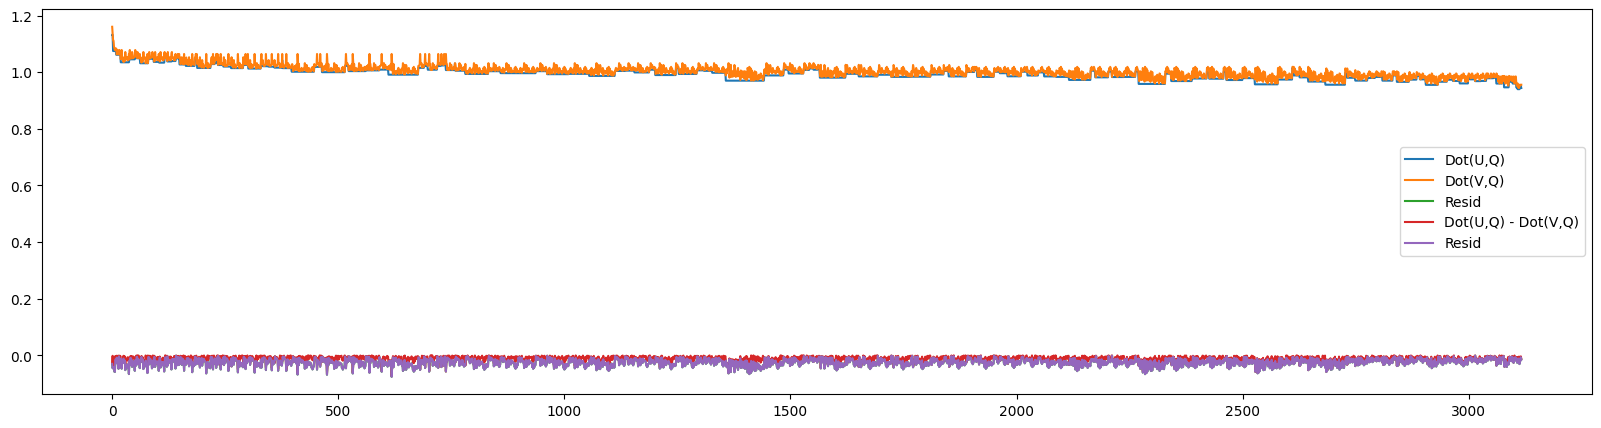

In [20]:
plt.figure(figsize=(20,5))
plt.plot( [ vec[0] for vec in ineq_doesnt_hold], label = "Dot(U,Q)" )
plt.plot( [ vec[1] for vec in ineq_doesnt_hold], label = "Dot(V,Q)" )
plt.plot( [ vec[2] for vec in ineq_doesnt_hold], label = "Resid" )
plt.plot( [ vec[0] - vec[1] for vec in ineq_doesnt_hold], label = "Dot(U,Q) - Dot(V,Q)" )

plt.plot( [ vec[2] for vec in ineq_doesnt_hold], label = "Resid" )

plt.legend()
plt.show()

[]

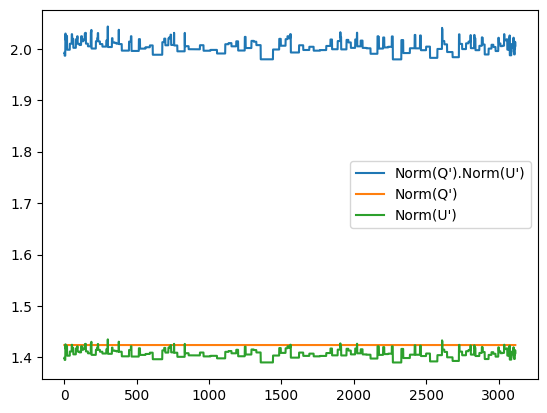

In [21]:
plt.plot( [ vec[3]*vec[4] for vec in ineq_doesnt_hold], label = "Norm(Q').Norm(U')" )
plt.plot( [ vec[3]        for vec in ineq_doesnt_hold], label = "Norm(Q')" )
plt.plot( [ vec[4]        for vec in ineq_doesnt_hold], label = "Norm(U')" )
plt.legend()
plt.plot()

## Recall@K Tests

In [73]:
# Function to compute recall@k
def recall_at_k(true_neighbors, predicted_neighbors, k):
    recalls = []
    for true, pred in zip(true_neighbors, predicted_neighbors):
        recall = len(set(true[:k]) & set(pred[:k])) / k
        recalls.append(recall)
    return np.mean(recalls)

### Initial d to D 

In [22]:
# Parameters
N = 200
d_values = [2, 3, 5, 10, 20, 50, 100, 1000]
D_values = [1000, 2000, 5000, 10000, 20000]
repeats = 10  # Optimized for faster runtime

# Function to compute recall@k
def recall_at_k(true_neighbors, predicted_neighbors, k):
    recalls = []
    for true, pred in zip(true_neighbors, predicted_neighbors):
        recall = len(set(true[:k]) & set(pred[:k])) / k
        recalls.append(recall)
    return np.mean(recalls)

# Store results
results = []

# Total iterations for progress bar
total_iterations = len(d_values) * len(D_values) * repeats

with tqdm(total=total_iterations, desc="Running experiments") as pbar:
    for d in d_values:
        for D in D_values:
            recall_1_list = []
            recall_5_list = []
            recall_10_list = []
            recall_100_list = []

            for _ in range(repeats):
                # Generate and normalize N vectors
                vectors = np.random.randn(N, d)
                normalized_vectors = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)

                # Compute original ranked neighbors
                original_sim = cosine_similarity(normalized_vectors)
                np.fill_diagonal(original_sim, -1)
                original_ranked_neighbors = np.argsort(-original_sim, axis=1)[:, :N-1]

                # Generate random ±1 projection matrix and project
                projection_matrix = 2 * np.random.randint(0, 2, size=(d, D)) - 1  # Faster ±1
                projected_vectors = normalized_vectors @ projection_matrix
                projected_vectors = projected_vectors / np.linalg.norm(projected_vectors, axis=1, keepdims=True)

                # Step: Add a constant vector of 1/D to each projected vector
                bias_vector = np.ones((1, D)) / D
                projected_vectors += bias_vector
                projected_vectors = projected_vectors / np.linalg.norm(projected_vectors, axis=1, keepdims=True)

                # Compute similarities in projected space
                projected_sim = cosine_similarity(projected_vectors)
                np.fill_diagonal(projected_sim, -1)
                projected_ranked_neighbors = np.argsort(-projected_sim, axis=1)[:, :N-1]

                # Compute recall@1, 5, 10
                recall_1_list.append(recall_at_k(original_ranked_neighbors, projected_ranked_neighbors, 1))
                recall_5_list.append(recall_at_k(original_ranked_neighbors, projected_ranked_neighbors, 5))
                recall_10_list.append(recall_at_k(original_ranked_neighbors, projected_ranked_neighbors, 10))
                recall_100_list.append(recall_at_k(original_ranked_neighbors, projected_ranked_neighbors, 100))

                pbar.update(1)

            # Store average of each recall
            results.append({
                'd': d,
                'D': D,
                'Recall@1': np.mean(recall_1_list),
                'Recall@5': np.mean(recall_5_list),
                'Recall@10': np.mean(recall_10_list),
                'Recall@100': np.mean(recall_100_list),
            })

# Convert to DataFrame
df_results = pd.DataFrame(results)


Running experiments:   0%|          | 0/400 [00:00<?, ?it/s]

Running experiments: 100%|██████████| 400/400 [01:26<00:00,  4.61it/s]


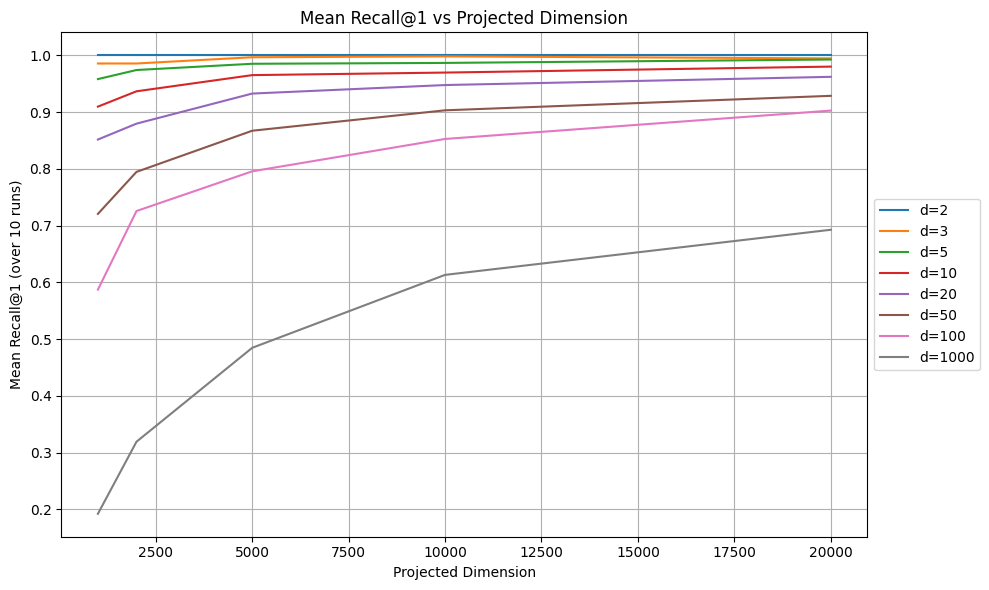

In [57]:
# Choose a subset of d values to plot
# subset_d_values = [2, 3]
subset_d_values = d_values  

# Plotting only Recall@1 for the selected d values
fig, ax = plt.subplots(figsize=(10, 6))
pivoted = df_results.pivot(index='D', columns='d', values='Recall@1')

# Filter only the subset columns
for d in subset_d_values:
    if d in pivoted.columns:
        ax.plot(pivoted.index, pivoted[d], label=f'd={d}')

ax.set_xlabel("Projected Dimension")
ax.set_ylabel("Mean Recall@1 (over 10 runs)")
ax.set_title("Mean Recall@1 vs Projected Dimension")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True)
plt.tight_layout()
plt.show()


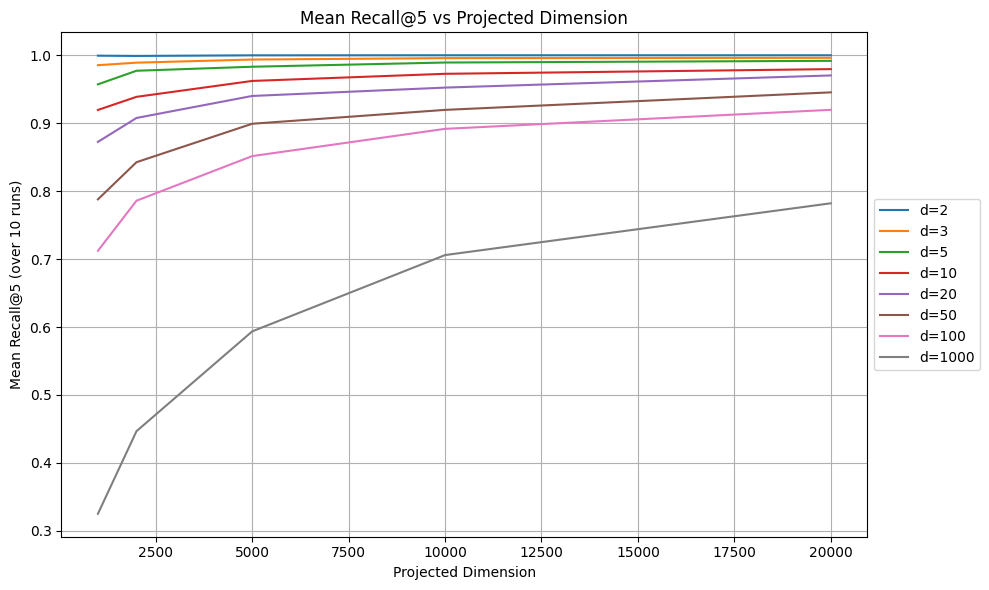

In [58]:
# Choose a subset of d values to plot
# subset_d_values = [2, 3]
subset_d_values = d_values  

# Plotting only Recall@1 for the selected d values
fig, ax = plt.subplots(figsize=(10, 6))
pivoted = df_results.pivot(index='D', columns='d', values='Recall@5')

# Filter only the subset columns
for d in subset_d_values:
    if d in pivoted.columns:
        ax.plot(pivoted.index, pivoted[d], label=f'd={d}')

ax.set_xlabel("Projected Dimension")
ax.set_ylabel("Mean Recall@5 (over 10 runs)")
ax.set_title("Mean Recall@5 vs Projected Dimension")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True)
plt.tight_layout()
plt.show()


### Different C values

In [83]:
# Parameters
N = 200
d = 1000
D_values = [100, 500, 2000, 5000, 10000]
c_values = [0.1, 1, 5, 10, 25, 50, 75, 100]
repeats = 30  # Optimized for faster runtime

# Store results
results_c = []

# Total iterations for progress bar
total_iterations = len(c_values) * len(D_values) * repeats

with tqdm(total=total_iterations, desc="Running experiments") as pbar:
    for c in c_values:
        for D in D_values:
            recall_1_list = []
            recall_5_list = []
            recall_10_list = []
            recall_100_list = []
            zero_count_list = []
            for _ in range(repeats):
                # Generate and normalize N vectors
                vectors = np.random.randn(N, d)
                normalized_vectors = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)

                # Compute original ranked neighbors
                original_sim = cosine_similarity(normalized_vectors)
                np.fill_diagonal(original_sim, -1)
                original_ranked_neighbors = np.argsort(-original_sim, axis=1)[:, :N-1]

                # Generate random ±1 projection matrix and project
                projection_matrix = 2 * np.random.randint(0, 2, size=(d, D)) - 1  # Faster ±1
                projected_vectors = normalized_vectors @ projection_matrix
                projected_vectors = projected_vectors / np.linalg.norm(projected_vectors, axis=1, keepdims=True)

                # Step: Add a constant vector of 1/D to each projected vector
                bias_vector = np.ones((1, D)) / D * c
                projected_vectors += bias_vector
                zero_count = np.sum(projected_vectors < 0)
                projected_vectors[projected_vectors < 0] = 0
                
                projected_vectors = projected_vectors / np.linalg.norm(projected_vectors, axis=1, keepdims=True)

                # Compute similarities in projected space
                projected_sim = cosine_similarity(projected_vectors)
                np.fill_diagonal(projected_sim, -1)
                projected_ranked_neighbors = np.argsort(-projected_sim, axis=1)[:, :N-1]

                # Compute recall@1, 5, 10
                recall_1_list.append(recall_at_k(original_ranked_neighbors, projected_ranked_neighbors, 1))
                recall_5_list.append(recall_at_k(original_ranked_neighbors, projected_ranked_neighbors, 5))
                recall_10_list.append(recall_at_k(original_ranked_neighbors, projected_ranked_neighbors, 10))
                recall_100_list.append(recall_at_k(original_ranked_neighbors, projected_ranked_neighbors, 100))
                zero_count_list.append(zero_count)

                pbar.update(1)

            # Store average of each recall
            results_c.append({
                'c': c,
                'D': D,
                'Recall@1': np.mean(recall_1_list),
                'Recall@5': np.mean(recall_5_list),
                'Recall@10': np.mean(recall_10_list),
                'Recall@100': np.mean(recall_100_list),
                'Zero Count': np.mean(zero_count_list),
            })

# Convert to DataFrame
df_results_c = pd.DataFrame(results_c)


Running experiments: 100%|██████████| 1200/1200 [01:46<00:00, 11.26it/s]


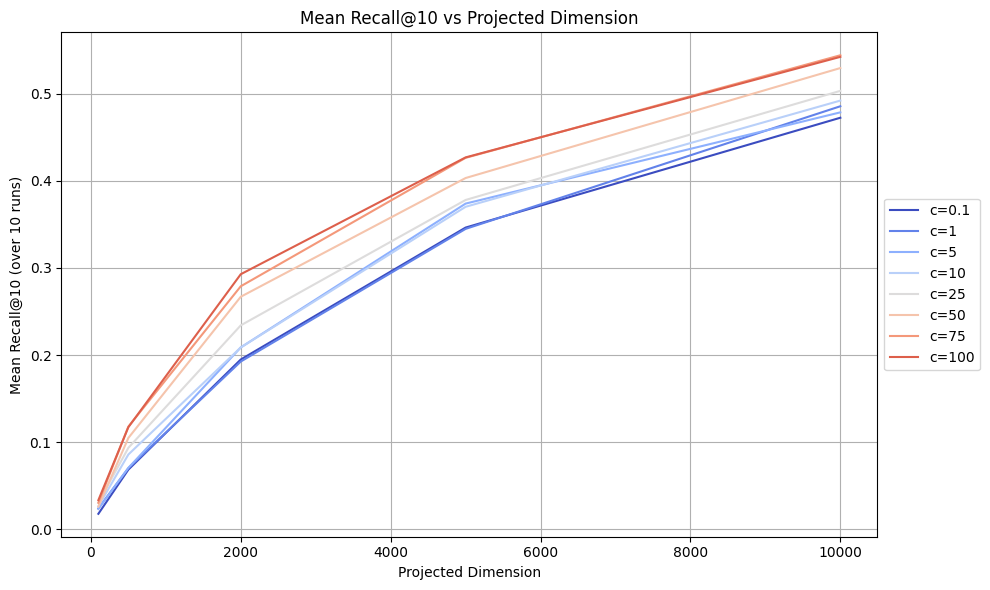

In [84]:
# Choose a subset of d values to plot
# subset_d_values = [2, 3]
subset_c_values = c_values  

# Plotting only Recall@1 for the selected d values
fig, ax = plt.subplots(figsize=(10, 6))
pivoted = df_results_c.pivot(index='D', columns='c', values='Recall@1')

# Filter only the subset columns and plot with color gradient
cmap = plt.get_cmap('coolwarm')
for i, c in enumerate(subset_c_values):
    if c in pivoted.columns:
        color = cmap(i / len(subset_c_values))
        ax.plot(pivoted.index, pivoted[c], label=f'c={c}', color=color)

ax.set_xlabel("Projected Dimension")
ax.set_ylabel("Mean Recall@10 (over 10 runs)")
ax.set_title("Mean Recall@10 vs Projected Dimension")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True)
plt.tight_layout()
plt.show()


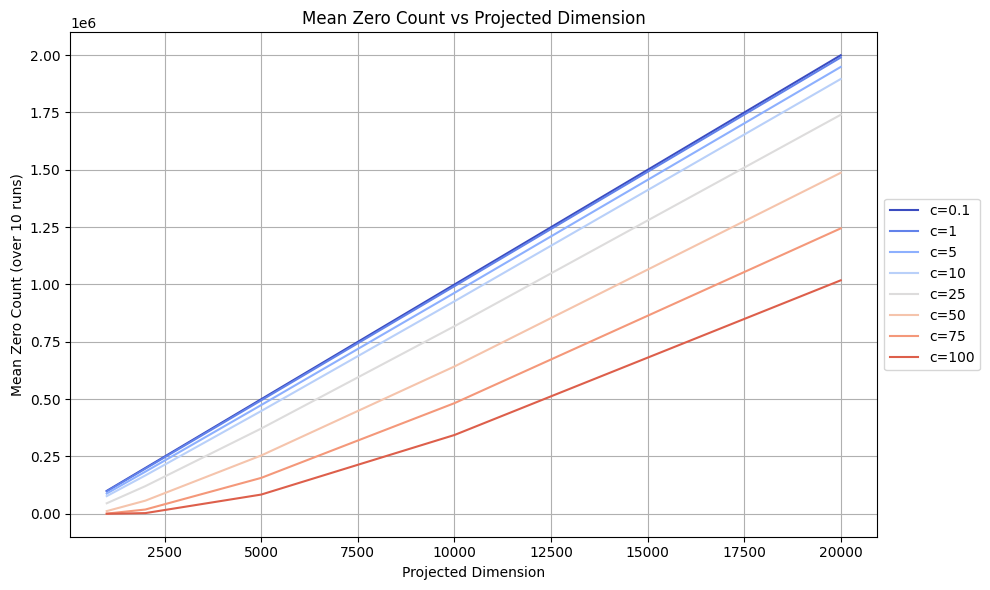

In [61]:
fig, ax = plt.subplots(figsize=(10, 6))
pivoted = df_results_c.pivot(index='D', columns='c', values='Zero Count')

# Filter only the subset columns and plot with color gradient
cmap = plt.get_cmap('coolwarm')
for i, c in enumerate(subset_c_values):
    if c in pivoted.columns:
        color = cmap(i / len(subset_c_values))
        ax.plot(pivoted.index, pivoted[c], label=f'c={c}', color=color)

ax.set_xlabel("Projected Dimension")
ax.set_ylabel("Mean Zero Count (over 10 runs)")
ax.set_title("Mean Zero Count vs Projected Dimension")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True)
plt.tight_layout()
plt.show()



### STD Datasets

In [74]:
target_dimension = 5000

In [75]:
def positive_normal_vector_like_C(D):
    # Generate absolute normal values
    vec = np.abs(np.random.normal(loc=0, scale=1, size=(1, D)))
    
    # if scale_sum_to_C:
    #     # Normalize to sum to C, similar to (1/D) * C
    #     vec = vec / np.sum(vec) * C
    
    return vec

In [76]:
def transform_and_normalize(V, projection_matrix, C):
    V_proj = V @ projection_matrix
    V_proj = V_proj / np.linalg.norm(V_proj, axis=1, keepdims=True)
    D = V_proj.shape[1]
    V_proj += np.ones((1, D)) / D * C
    # V_proj += np.random.uniform(0, 1, size=(1, D))
    # V_proj = positive_normal_vector_like_C(D)
    V_proj = V_proj / np.linalg.norm(V_proj, axis=1, keepdims=True)
    return V_proj

def knn_snn(V, projection_matrix, C):

    results = {}

    # N = V.shape[0]
    N = 200

    recall_1_list = None
    recall_5_list = None
    recall_10_list = None
    recall_100_list = None

    original_sim = cosine_similarity(V)
    np.fill_diagonal(original_sim, -1)
    original_ranked_neighbors = np.argsort(-original_sim, axis=1)[:, :N-1]
    
    V_proj = transform_and_normalize(V, projection_matrix, C)
    
    
    # Compute similarities in projected space
    projected_sim = cosine_similarity(V_proj)
    np.fill_diagonal(projected_sim, -1)
    projected_ranked_neighbors = np.argsort(-projected_sim, axis=1)[:, :N-1]

    # Compute recall@1, 5, 10
    recall_1_list = recall_at_k(original_ranked_neighbors, projected_ranked_neighbors, 1)
    recall_5_list = recall_at_k(original_ranked_neighbors, projected_ranked_neighbors, 5)
    recall_10_list = recall_at_k(original_ranked_neighbors, projected_ranked_neighbors, 10)
    recall_100_list = recall_at_k(original_ranked_neighbors, projected_ranked_neighbors, 100)

    results['Recall@1'] = recall_1_list
    results['Recall@5'] = recall_5_list
    results['Recall@10'] = recall_10_list
    results['Recall@100'] = recall_100_list

    return results  



In [77]:
# Store results
results = {}

# Loop through datasets, load, normalize, and run knn_snn
for name, dataset in datasets.items():
    V = dataset
    print(f'Dataset: {name}, Shape: {V.shape}')
    projection_matrix = np.random.randn(V.shape[1], target_dimension) 
    C = 10
    results[name] = knn_snn(V, projection_matrix, C)



Dataset: mnist, Shape: (500, 784)
Dataset: iris, Shape: (150, 4)
Dataset: wine, Shape: (178, 13)
Dataset: spambase, Shape: (4601, 57)
Dataset: energy-efficiency, Shape: (768, 9)
Dataset: random, Shape: (500, 20)


In [78]:
# Convert to DataFrame for display
results_df = pd.DataFrame(results).T

In [79]:
results_df

,Recall@1,Recall@5,Recall@10,Recall@100
mnist,0.960000,0.955600,0.962600,0.962020
iris,0.993333,0.992000,0.990000,0.998533
wine,0.988764,0.993258,0.992135,0.996011
spambase,0.876331,0.936536,0.946881,0.984888
energy-efficiency,0.644531,0.934896,0.961068,0.980794
random,0.920000,0.927200,0.933200,0.963960


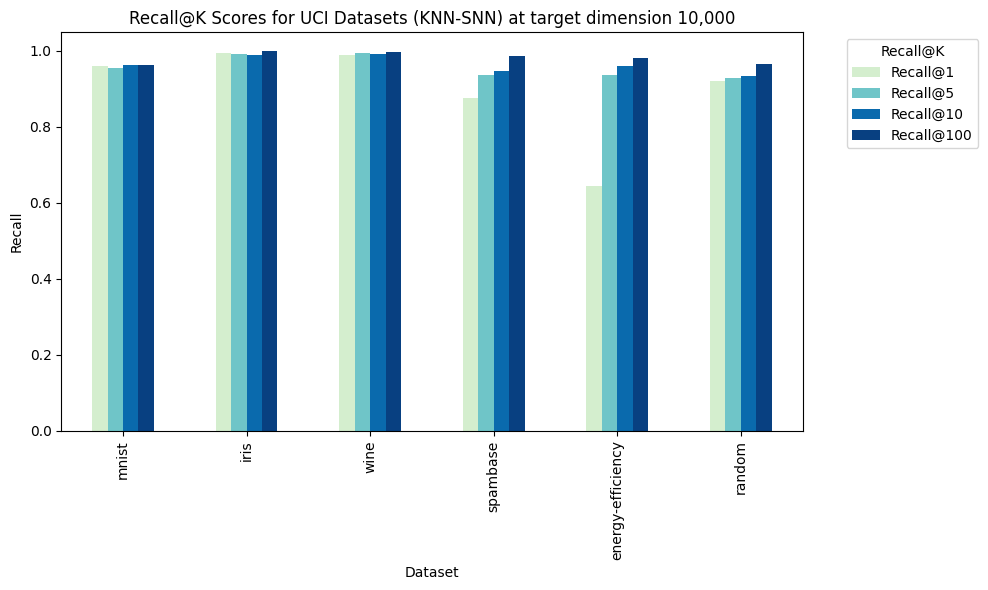

In [80]:
# Remove rows where 'Recall@1' is NaN
results_df_cleaned = results_df.dropna(subset=['Recall@1'])

# Create color mapping from colormap (one color per Recall@K group)
cmap = plt.get_cmap('GnBu')
num_bars = len(results_df_cleaned.columns)
colors = [cmap(i / (num_bars - 1) + 0.2) for i in range(num_bars)]

# Plot with colors sampled from the colormap
ax = results_df_cleaned.plot(kind='bar', figsize=(10, 6), color=colors)
plt.title("Recall@K Scores for UCI Datasets (KNN-SNN) at target dimension 10,000")
plt.ylabel("Recall")
plt.xlabel("Dataset")
# plt.grid(axis='y')

# Move legend outside the plot area
plt.legend(title="Recall@K", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Dot Product Calculations

In [81]:
list_datasets = [
    'iris',
    'wine',
    'mnist',
    'random',
    # 'energy-efficiency',
]


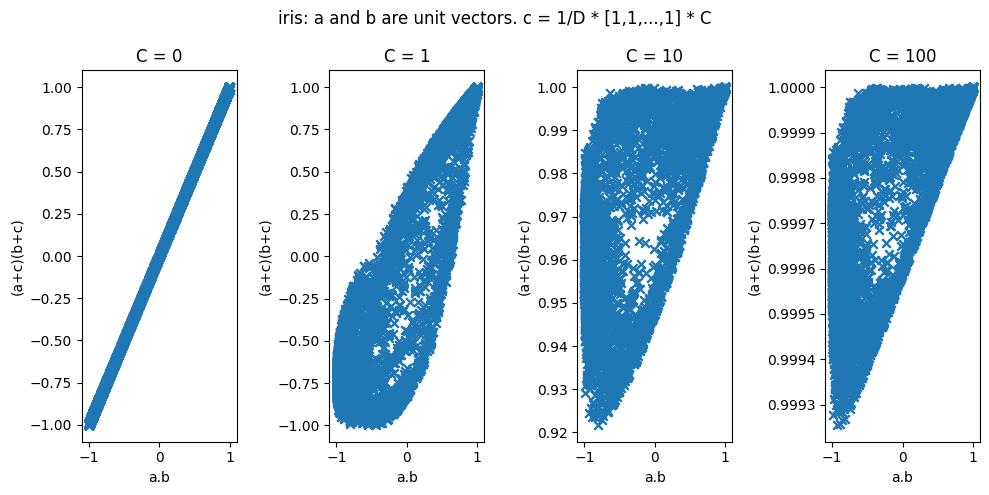

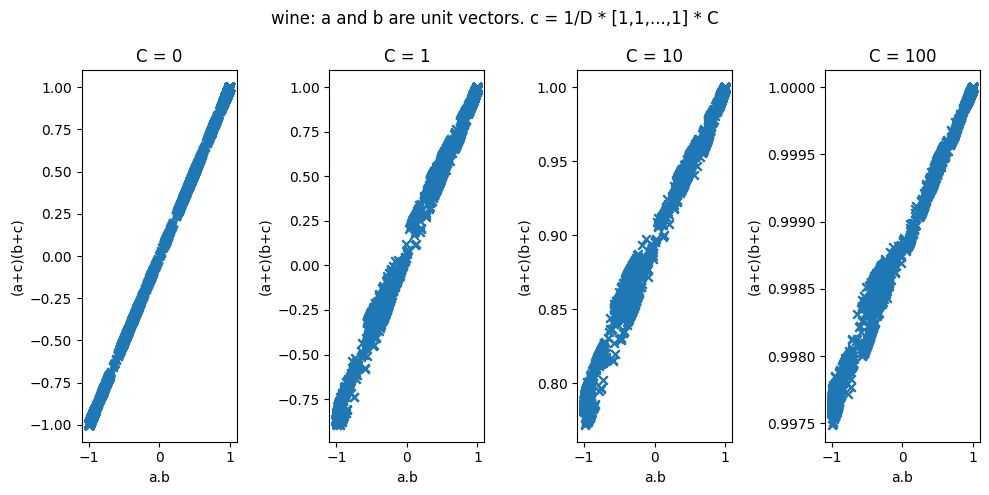

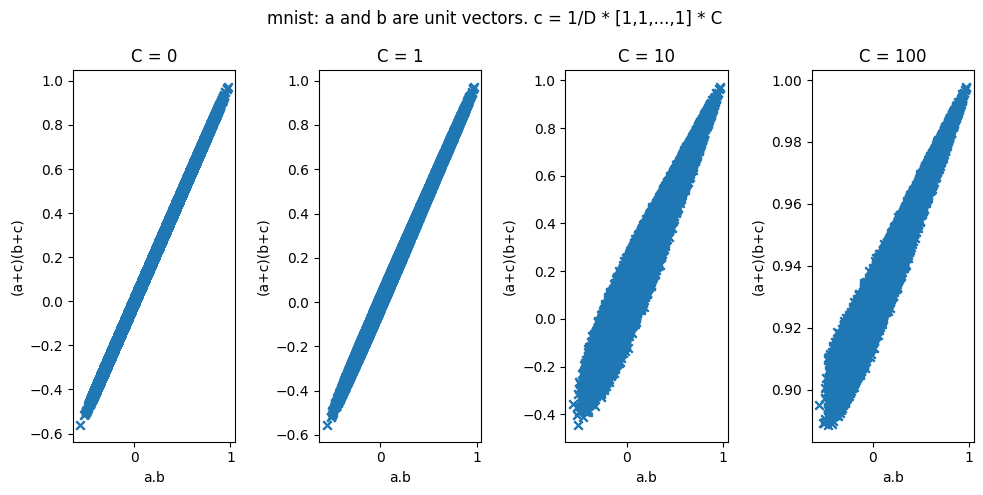

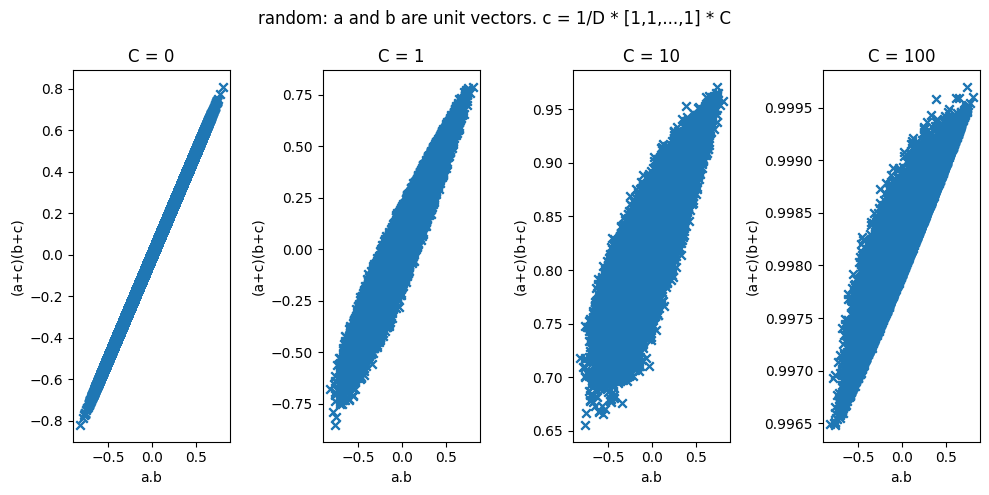

In [93]:
for dataset_name in list_datasets:
    dataset = datasets[dataset_name]
    
    # Define C values to test
    C_values = [0, 1, 10, 100]
    
    plt.figure(figsize=(10, 5))
    
    for idx, C in enumerate(C_values):
        orig_dot = []
        augm_dot = []

        for i in range(dataset.shape[0]):
            for j in range(dataset.shape[0]):
                if i == j:
                    continue
                orig_dot.append(np.dot(dataset[i], dataset[j]))
                # print(dataset[i].shape, dataset[j].shape)
                aug_i = dataset[i] + (np.ones((dataset.shape[1])) / dataset.shape[1]) * C
                aug_j = dataset[j] + (np.ones((dataset.shape[1])) / dataset.shape[1]) * C
                # Normalize the augmented vectors
                aug_i = aug_i / np.linalg.norm(aug_i)
                aug_j = aug_j / np.linalg.norm(aug_j)
                # print(aug_i.shape, aug_j.shape)
                augm_dot.append(np.dot(aug_i, aug_j))

        plt.subplot(1, len(C_values), idx+1)
        # Create a colormap that transitions from red to blue based on index
        colors = plt.cm.viridis(np.linspace(0, 1, len(orig_dot)))
        plt.scatter(orig_dot, augm_dot, marker='x')
        plt.xlabel('a.b')
        plt.ylabel('(a+c)(b+c)')
        # plt.ylim(-1, 1)  # Set y-axis limits from -1 to 1
        plt.title(f'C = {C}')
    
    plt.suptitle(f'{dataset_name}: a and b are unit vectors. c = 1/D * [1,1,...,1] * C')
    plt.tight_layout()
    plt.show()

In [85]:
len(orig_dot)

249500

In [86]:
len(augm_dot)


249500

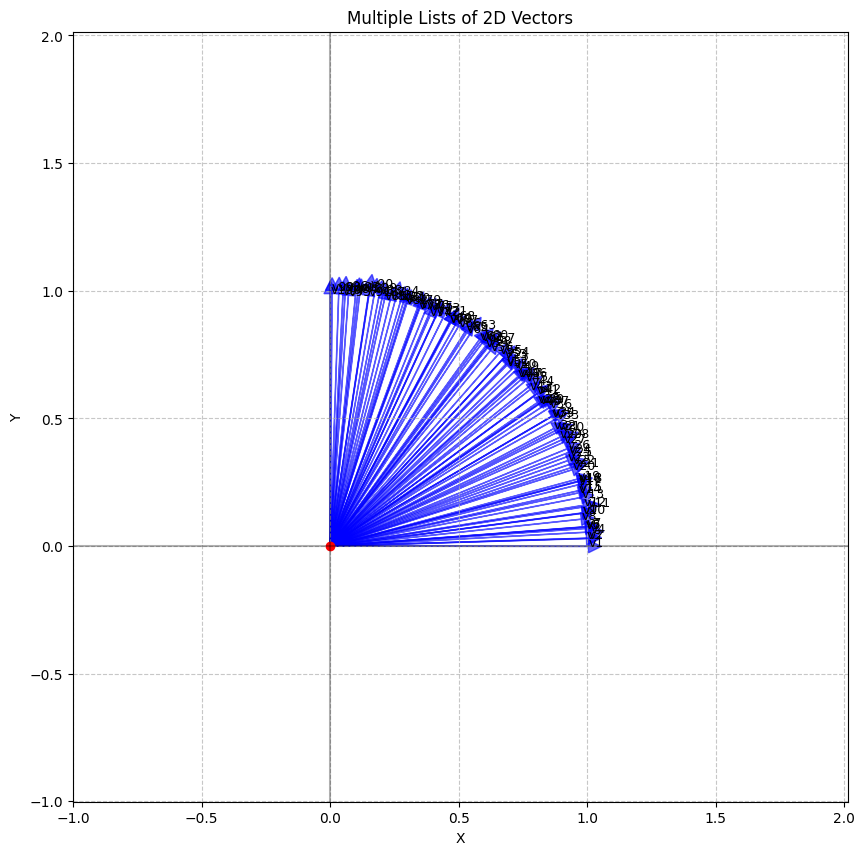

In [67]:

# Set random seed for reproducibility
np.random.seed(42)

# Generate 30 vectors in the unit circle, that are equally separated
angles = np.linspace(0, np.pi*0.5, 100)
vectors = np.column_stack((np.cos(angles), np.sin(angles)))

# vectors = np.random.uniform(-1, 1, (30, 5000))
# vectors = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)

vectors = vectors[(vectors[:, 1] >= 0) & (vectors[:, 0] >= 0)]
vectors += np.random.normal(0, 0.01, vectors.shape)
# vectors = D1

# vectors = np.random.uniform(-1, 1, (30, 2))
# vectors = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)

def plot_vectors(list_of_vectors, colors=['b', 'r'], max_val=None, min_val=None, is_arrow=True, x_limit=None, y_limit=None):
    plt.figure(figsize=(10, 10))
    # Check if any of the vectors in the list are of higher dimensions than 2
    for vectors in list_of_vectors:
        if vectors.shape[1] > 2:
            # If so, do a PCA and plot the 2 most significant dimensions
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            vectors_2d = pca.fit_transform(vectors)
            vectors = vectors_2d

    # Plot each vector as an arrow from the origin
    for vectors, color in zip(list_of_vectors, colors):
        for i, vec in enumerate(vectors):
            # Plot the vector as an arrow from origin (0,0) to (x,y)
            if is_arrow:
                plt.arrow(0, 0, vec[0], vec[1], head_width=0.05, head_length=0.05, 
                        fc=color, ec=color, alpha=0.6)
            else:
                plt.plot(vec[0], vec[1], f'{color}o')
            
            # Add a label for each vector
            plt.text(vec[0], vec[1], f'v{i+1}', fontsize=9)

    # Plot a point at the origin
    plt.plot(0, 0, 'ro')

    # Set axis limits with some padding
    if max_val is None:
        max_val = np.max(np.concatenate(list_of_vectors)) + 1
    if min_val is None:
        min_val = np.min(np.concatenate(list_of_vectors)) - 1

    # Set custom x and y limits if provided
    if x_limit is not None:
        plt.xlim(x_limit[0], x_limit[1])
    else:
        plt.xlim(min_val, max_val)

    if y_limit is not None:
        plt.ylim(y_limit[0], y_limit[1])
    else:
        plt.ylim(min_val, max_val)

    # Add grid, title and labels
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.title('Multiple Lists of 2D Vectors')
    plt.xlabel('X')
    plt.ylabel('Y')

    # Show the plot
    plt.show()

# Call the function to plot the vectors
plot_vectors([vectors])

# # Optional: Print the vector values
# print("Random vectors:")
# for i, vec in enumerate(vectors):
#     print(f"v{i+1}: ({vec[0]:.2f}, {vec[1]:.2f})")

In [50]:
from scipy.spatial import distance

def get_closest_neighbors(vector, all_vectors):
    # Calculate distances to all other vectors
    distances = [distance.cosine(vector, v) for v in all_vectors]
    
    # Create pairs of (index, distance)
    indexed_distances = list(enumerate(distances))
    
    # Sort by distance (excluding self - distance=0)
    sorted_neighbors = sorted(indexed_distances, key=lambda x: x[1])
    
    # Remove the first element (self)
    sorted_neighbors = sorted_neighbors[1:]
    
    # Return list of indices sorted by distance
    return [idx + 1 for idx, dist in sorted_neighbors]


In [51]:
closest_neighbors = []
for i, vec in enumerate(vectors):
    neighbors = get_closest_neighbors(vec, vectors)
    closest_neighbors.append(neighbors)

## Add positive constant

In [52]:
vectors_shift = [np.add(vec, 1) for vec in vectors]
print(vectors_shift)    

[array([2.00496714, 0.99861736]), array([2.00635101, 1.03109626]), array([1.99715501, 1.02938656]), array([2.01465947, 1.05525626]), array([1.99329193, 1.06884952]), array([1.9922206 , 1.07459266]), array([1.99789155, 1.07592324]), array([1.97658929, 1.10521532]), array([1.9818265 , 1.12973493]), array([1.9807412, 1.1281918]), array([2.00209538, 1.15574363]), array([1.98548304, 1.1594007 ]), array([1.97648487, 1.19036047]), array([1.96729251, 1.20856365]), array([1.9694234, 1.2173936]), array([1.9657945 , 1.25428172]), array([1.96781373, 1.24057088]), array([1.97206761, 1.25426538]), array([1.96158161, 1.26213586]), array([1.94162038, 1.29888899]), array([1.95745578, 1.31374713]), array([1.94384434, 1.32405693]), array([1.9249074, 1.3348217]), array([1.92954147, 1.36745744]), array([1.93180412, 1.35403205]), array([1.92559513, 1.3824943 ]), array([1.90933924, 1.4070473 ]), array([1.91994199, 1.42472781]), array([1.89453436, 1.42670279]), array([1.89930641, 1.45382206]), array([1.884043

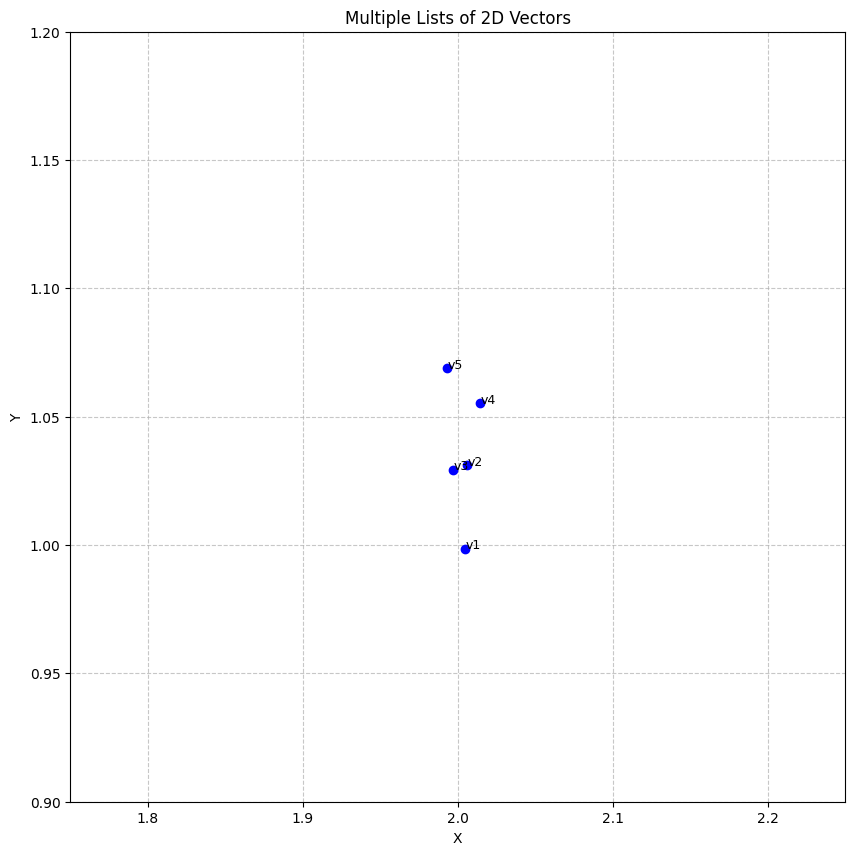

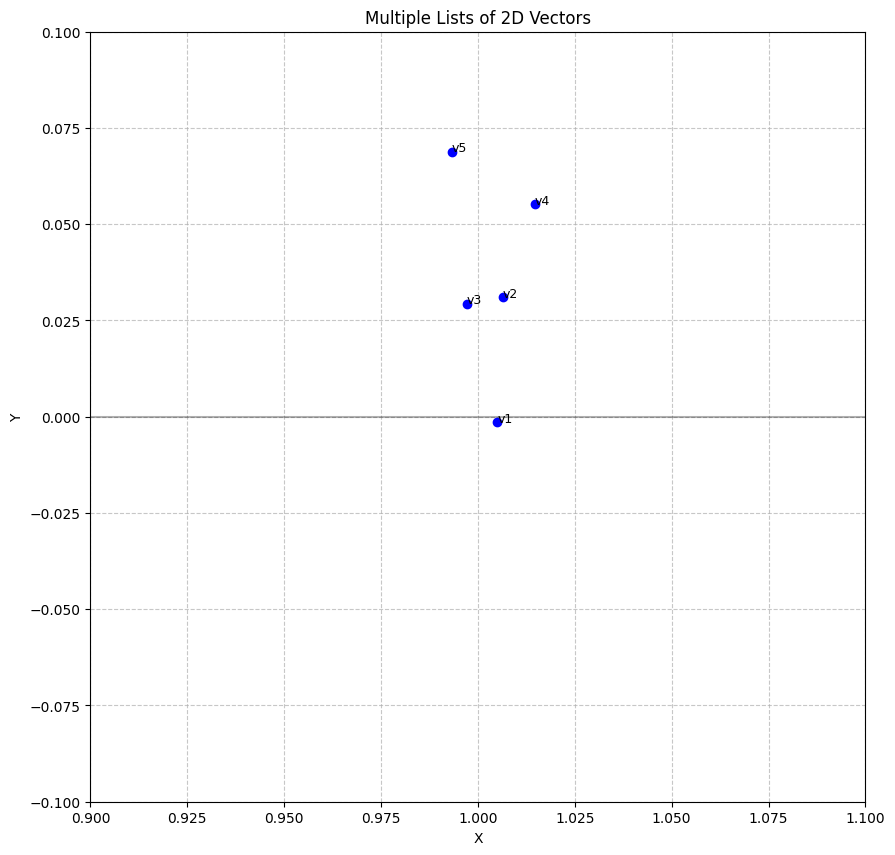

In [70]:
plot_vectors([np.array(vectors_shift)[:5]], x_limit=[1.75, 2.25], y_limit=[0.9, 1.2], is_arrow=False)
plot_vectors([np.array(vectors)[:5]], x_limit=[0.9, 1.1], y_limit=[-0.1, 0.1], is_arrow=False)

In [54]:
from scipy.spatial.distance import cosine
print(cosine(vectors_shift[5], vectors_shift[6]))
print(cosine(vectors_shift[5], vectors_shift[8]))
print(cosine(vectors_shift[5], vectors_shift[9]))

2.246774637448823e-07
0.0002747037696408938
0.00026650808358075206


In [55]:
closest_neighbors_shift = []
for i, vec in enumerate(vectors_shift):
    neighbors = get_closest_neighbors(vec, vectors_shift)
    closest_neighbors_shift.append(neighbors)

In [56]:
#check if the closest neighbors are the same
print(closest_neighbors == closest_neighbors_shift)



False


In [57]:
for i, vec in enumerate(vectors):
    print(closest_neighbors[i])


[3, 2, 4, 5, 6, 7, 8, 10, 9, 11, 12, 13, 14, 15, 17, 18, 16, 19, 20, 21, 22, 23, 25, 24, 26, 27, 28, 29, 30, 31, 32, 33, 35, 34, 36, 37, 39, 40, 38, 42, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
[3, 4, 1, 5, 6, 7, 8, 10, 9, 11, 12, 13, 14, 15, 17, 18, 16, 19, 20, 21, 22, 23, 25, 24, 26, 27, 28, 29, 30, 31, 32, 33, 35, 34, 36, 37, 39, 40, 38, 42, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
[2, 4, 1, 5, 6, 7, 8, 10, 9, 11, 12, 13, 14, 15, 17, 18, 16, 19, 20, 21, 22, 23, 25, 24, 26, 27, 28, 29, 30, 31, 32, 33, 35, 34, 36, 37, 39, 40, 38, 42, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 53, 55, 56, 57, 58,

In [58]:
for i, vec in enumerate(vectors_shift):
    print(closest_neighbors_shift[i])


[2, 3, 4, 5, 7, 6, 8, 10, 9, 11, 12, 13, 14, 15, 17, 18, 16, 19, 20, 21, 22, 23, 25, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 38, 42, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 81, 83, 84, 85, 86, 87, 88, 89, 91, 90, 92, 93, 94, 95, 97, 96, 98, 100, 99]
[3, 4, 1, 5, 7, 6, 8, 10, 9, 11, 12, 13, 14, 15, 17, 18, 16, 19, 20, 21, 22, 23, 25, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 38, 42, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 81, 83, 84, 85, 86, 87, 88, 89, 91, 90, 92, 93, 94, 95, 97, 96, 98, 100, 99]
[2, 4, 1, 5, 7, 6, 8, 10, 9, 11, 12, 13, 14, 15, 17, 18, 16, 19, 20, 21, 22, 23, 25, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 38, 42, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 53, 55, 56, 57, 58,

## Normalize the shift

In [59]:
vectors_shift_norm = vectors_shift / np.linalg.norm(vectors_shift, axis=1, keepdims=True)

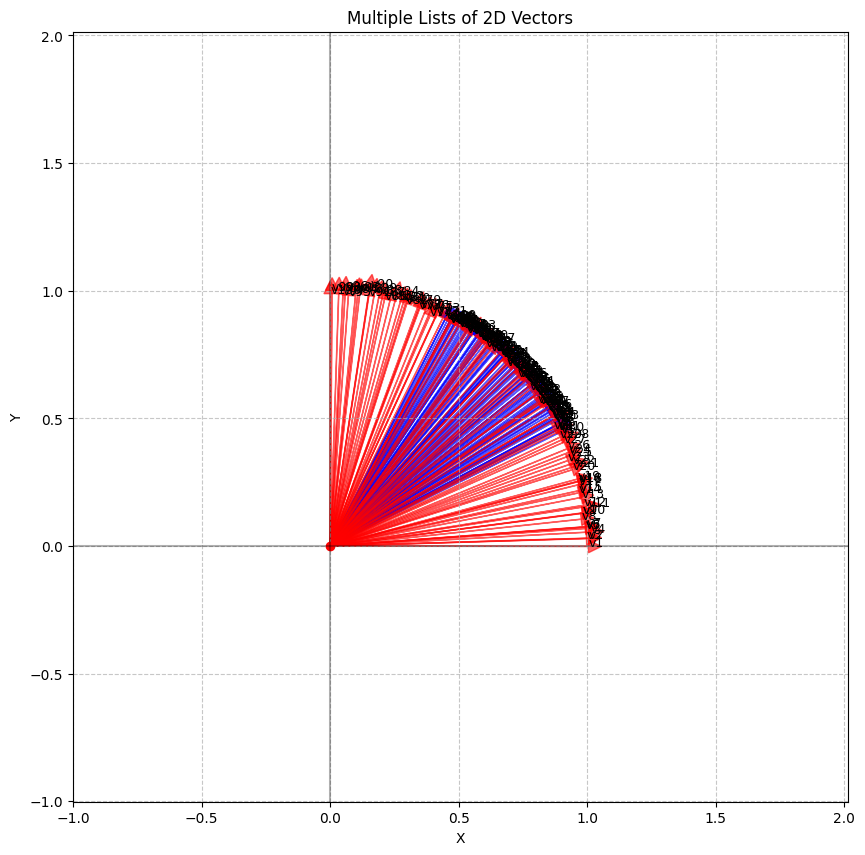

In [71]:
plot_vectors([vectors_shift_norm, vectors])

## Mean Center Normalization

In [80]:
from dot_product import ScaleDatabase

mu1 = np.mean(D1,axis=0)
D1_centered = np.subtract(D1,mu1)


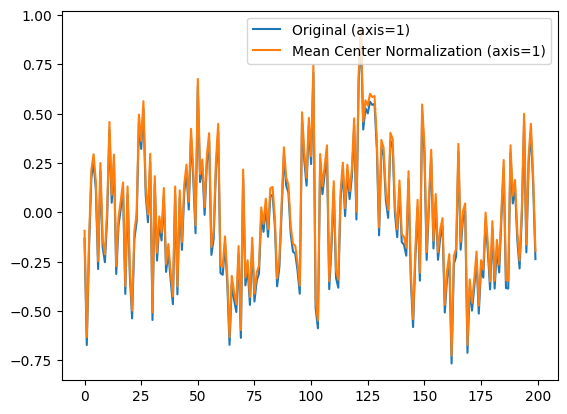

In [89]:

# plt.plot(np.mean(D1, axis=0), label='Original (axis=0)')
plt.plot(np.mean(D1, axis=1), label='Original (axis=1)')
# plt.plot(  np.mean(D1_centered, axis=0), label='Mean Center Normalization (axis=0)')
plt.plot(np.mean(D1_centered, axis=1), label='Mean Center Normalization (axis=1)')
plt.legend()
plt.show()


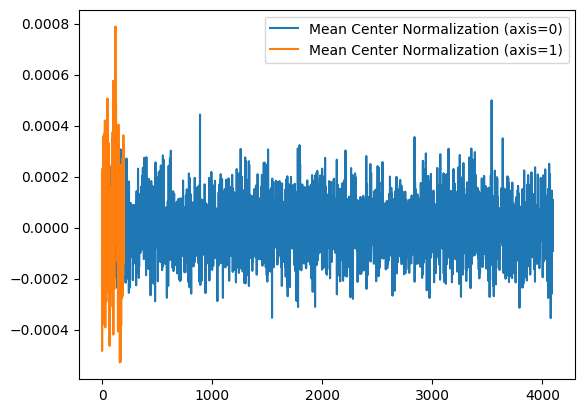

In [ ]:
D1_mean_center_norm = ScaleDatabase().mean_center_normalize(D1)

plt.plot(np.mean(D1_mean_center_norm, axis=0), label='Mean Center Normalization (axis=0)')
plt.plot(np.mean(D1_mean_center_norm, axis=1), label='Mean Center Normalization (axis=1)')
plt.legend()
plt.show()





In [91]:
np.mean(np.mean(D1_mean_center_norm, axis=1))

1.7844915137189246e-06

In [95]:
# D1_mean_center_norm

sim_matrix = np.dot(D1_mean_center_norm, D1_mean_center_norm.T)


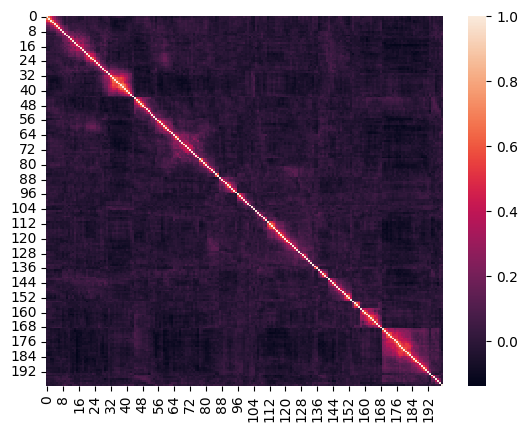

In [96]:
import seaborn as sns

ax = sns.heatmap(sim_matrix)
plt.show()

In [97]:
np.mean(sim_matrix)

3.984505363004516e-05

## Exact Dot Product

In [11]:
from dot_product import LoihiExactDotProduct

In [14]:
s_d = 500
s_q = 500

# Store results
results = {}

# Store results for exact dot product
exact_dot_results = {}
snn_dot_exact_results = {}

# Loop through datasets
for name, dataset in datasets.items():
    V = dataset
    print(f'Processing exact dot product for dataset: {name}, Shape: {V.shape}')
    
    # Initialize matrix to store dot product results
    n_samples = V.shape[0]
    dot_product_matrix = np.zeros((n_samples, n_samples))
    snn_dot_exact_matrix = np.zeros((n_samples, n_samples))
    
    # Calculate dot product for each unique pair
    for i in tqdm(range(n_samples)):
        for j in range(i+1, n_samples):  # Only compute upper triangle (unique pairs)

            D = len(V[i])
            # Compute exact dot product
            dot_val = np.dot(V[i], V[j])
            snn_dot = LoihiExactDotProduct(np.array([V[i]]), np.array([V[j]]), 0, timesteps=50, dbScale=0).run(customTimesteps=49)[0][0]

            d_min = abs(np.min(V[i]))
            q_min = abs(np.min(V[j]))
            orig_dot_derived = snn_dot * (np.linalg.norm(V[i] + d_min) * np.linalg.norm(V[j] + q_min)) / (s_d * s_q) - q_min*np.sum(V[i]) - d_min*np.sum(V[j]) - q_min*d_min*D
            
            # Store in symmetric matrix
            dot_product_matrix[i, j] = dot_val
            dot_product_matrix[j, i] = dot_val  # Mirror value for symmetric matrix
            snn_dot_exact_matrix[i, j] = orig_dot_derived
            snn_dot_exact_matrix[j, i] = orig_dot_derived
    
    # Store diagonal values (dot product with self)
    for i in range(n_samples):
        dot_product_matrix[i, i] = np.dot(V[i], V[i])
    
    # Store results
    exact_dot_results[name] = dot_product_matrix
    snn_dot_exact_results[name] = snn_dot_exact_matrix
    
    # Visualize first few rows/columns if dataset is not too large
    if n_samples <= 100:
        plt.figure(figsize=(10, 10))
        sns.heatmap(dot_product_matrix, cmap='viridis')
        plt.title(f'Exact Dot Product Matrix for {name}')
        plt.show()

Processing exact dot product for dataset: mnist, Shape: (500, 784)


100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

lif_2.u.get(): [0.]



100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

lif_2.u.get(): [0.]



100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

lif_2.u.get(): [0.]



100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

lif_2.u.get(): [0.]



100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

lif_2.u.get(): [0.]



100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

lif_2.u.get(): [0.]



100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

lif_2.u.get(): [0.]



100%|██████████| 1/1 [00:00<00:00,  7.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.49it/s]

lif_2.u.get(): [0.]



100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

lif_2.u.get(): [0.]



100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.43it/s].00s/it]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

lif_2.u.get(): [0.]



100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

lif_2.u.get(): [0.]



100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  3.19it/s].19s/it]

lif_2.u.get(): [0.]



100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 23.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 23.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 23.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 23.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 23.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 23.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 23.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 23.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 23.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 23.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 23.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 23.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 23.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.69it/s]81.03s/it]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 23.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 23.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 23.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 23.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 24.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 23.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 23.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 23.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 22.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 23.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.24it/s]55.50s/it]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.89it/s]61.97s/it]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.07it/s]10.92s/it]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.18it/s]72.13s/it]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.68it/s]35.14s/it]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 26.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 28.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.39it/s]53.14s/it]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.26it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

lif_2.u.get(): [0.]



100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.42it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

lif_2.u.get(): [0.]



100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.29it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.67it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.18it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.63it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.44it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.22it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 15.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 16.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.28it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.68it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.71it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.77it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.61it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.62it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.11it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.19it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.15it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 19.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  6.82it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 21.04it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 18.84it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00,  7.17it/s]


lif_2.u.get(): [0.]


100%|██████████| 1/1 [00:00<00:00, 13.85it/s]


lif_2.u.get(): [0.]


  2%|▏         | 9/500 [6:55:30<377:48:23, 2770.07s/it]


KeyboardInterrupt: 

In [ ]:
np.random.seed(43)
from tqdm import tqdm

snn_dot_exact_lst = []
exact_dot_lst = []
orig_dot_lst = []
orig_dot_derived_lst = []

for i in tqdm(range(100)):
    d_original = np.random.randn(D) 
    q_original = np.random.randn(D) 

    d_min = abs(np.min(d_original))
    q_min = abs(np.min(q_original))

    d = (d_original + d_min) / np.linalg.norm(d_original + d_min)
    q = (q_original + q_min) / np.linalg.norm(q_original + q_min)

    s_d = 500
    s_q = 500

    d_scaled = s_d * d
    q_scaled = s_q * q

    t = 50
    dot_loihi_exact = LoihiExactDotProduct(np.array([d_scaled]), np.array([q_scaled]), 0, timesteps=t, dbScale=0)
    snn_dot = dot_loihi_exact.run(customTimesteps=t-1)[0][0]

    snn_dot_exact = snn_dot / (s_d * s_q)
    exact_dot     = np.dot(d,q)
    orig_dot      = np.dot(d_original, q_original)
    orig_dot_derived = snn_dot * (np.linalg.norm(d_original + d_min) * np.linalg.norm(q_original + q_min)) / (s_d * s_q) - q_min*np.sum(d_original) - d_min*np.sum(q_original) - q_min*d_min*D


    snn_dot_exact_lst.append(snn_dot_exact)
    exact_dot_lst.append(exact_dot)
    orig_dot_lst.append(orig_dot)
    orig_dot_derived_lst.append(orig_dot_derived)
